# Getting the Bugs Out
### Troubleshooting Code in Python

In this workshop we'll look at some examples of Python code that's not working as intended or that could be improved, and we'll implement strategies to do so.

### Introduction

#### Discussion Question

What makes good software (vs. bad software)? 

#### Four R's

1. Reliability
2. Robustness
3. Readability
4. Reproducibility

Reliability = Does it perform as expected in the presence of valid inputs?

Robustness = Does it handle invalid inputs gracefully?

Readability = Can others with relevant expertise -- other than the code's author -- understand the code and what it is intended to do?

Reproducibility = Can others use the code on the same inputs and achieve the same (or equivalent) results?


#### Learning objectives
In this workshop, we'll focus on reliability/robustness, looking at examples of code that doesn't perform as expected and revising them make to the code more error-proof. Along the way, we'll talk about best practices that can also make code more readable and reproducible.


### Understanding exceptions in Python

#### Example 1: Analyzing Twitter data

Data from the Twitter API is in [JSON-L](https://jsonlines.org/) format, in which each line of a text file is a valid string in JSON (JavaScript Object Notation). 

We have a file containing a couple thousand Tweets by U.S. Senators. They are all (are should be all) retweets -- meaning, instances where the Twitter user has retweeted someone else's Tweet. 

We want to parse this file and examine which accounts are being retweeted by which Senators?

#### Loading and parsing JSON-L data

Our first step is to import a couple of libraries we'll need for this task.

In [10]:
import requests
import jsonlines

Now we'll load the Twitter dataset (originally retrieved from GW LAI's [TweetSets](https://tweetsets.library.gwu.edu/) platform, but hosted here on GitHub for convenience).

In [11]:
data = requests.get('https://raw.githubusercontent.com/gwu-libraries/gwlibraries-workshops/master/python-debugging/sample-retweets.jsonl')

Now let's parse this data with the `jsonlines` module, which lets us iterate over a sequence of JSON objects in a file, converting each to Python data structures.

1. Create a `Reader` object. 
2. Use a [list comprehension](https://realpython.com/list-comprehension-python/) to collect each Tweet in a list called `tweets`.

In [12]:
reader = jsonlines.Reader(data)
tweets = [r for r in reader]

InvalidLineError: line contains invalid json: Expecting ':' delimiter: line 1 column 129 (char 128) (line 1)

If you ran the above, you should have gotten an `InvalidLineError`. What do we do now?

Two Approaches
1. Panic
   a. Try as many different modifications of the code as you can think of until something works.
   b. Google the error and start copy-pasting code snippets from stackoverflow.
   c. Abandon this method of loading the data and try something else entirely.
2. Interpet the error to diagnose the exact nature of the problem.

**Note**: Panic is a perfectly _normal_ response. As a seasoned developer, I frequently feel panic when seeing an unexpected error in my code, especially if I'm working on a deadline, or using a new library or language, or doing something that's worked correctly a hundred times before. And sometimes trial-and-error/copy-pasting is the most efficient way to solve a problem.

But unlike some languages, Python is written with care for its exceptions. They are crafted to be readable, informative, and specific. 

#### Anatomy of a Python exception

- Exception = an outcome of a command that the Python interpreter did not anticipate. (Not necessarily an error in the sense of a mistake.)
- Includes one or more "tracebacks." These show the **stack trace**: the nested sequence of Python instructions that the interpreter was trying to execute when it triggered the exception.
- Read each traceback from the top down. Most of the code shown (in this case) is not code we wrote, but code that our code refers to (under the hood). 
- Understand the sequence of tracebacks, using the messages between them. In this case, the first exception in the list is the most immediate: in this case, a `JSONDecodeError`.
- The tracebacks will tell you which Python module/package is causing the exception, which can be helpful in troubleshooting.



Since the exception was caused by our list comprehension, and since it's a JSON-related error, we might reason that something is not working properly with the `reader` object we created. Looking at the [documentation](https://jsonlines.readthedocs.io/en/latest/#jsonlines.Reader) for `jsonlines.Reader`, we see the following:
```
The first argument must be an iterable that yields JSON encoded strings. Usually this will be a readable file-like object, such as an open file or an io.TextIO instance, but it can also be something else as long as it yields strings when iterated over.
```

So the `Reader` object only works on something that _yields strings when iterated over_. The next question is, Does our `data` object meet that requirement? Let's test it.

In [18]:
[d for d in data]

[b'{"id_str": "1131004407917830150", "favorite_count": 0, "created_at": "Wed May 22 01:10:38 +0000 2019", "in_reply_to_screen_name"',
 b': null, "truncated": false, "is_quote_status": false, "geo": null, "retweeted_status": {"id_str": "1130477008268480512", "geo": ',
 b'null, "created_at": "Mon May 20 14:14:56 +0000 2019", "in_reply_to_screen_name": null, "truncated": false, "is_quote_status": fa',
 b'lse, "favorite_count": 17, "lang": "en", "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "user": {"favourites_coun',
 b't": 20291, "time_zone": null, "profile_sidebar_fill_color": "BAC9D6", "contributors_enabled": false, "is_translation_enabled": f',
 b'alse, "profile_image_url_https": "https://pbs.twimg.com/profile_images/875393694538584065/7r1LF8WG_normal.jpg", "utc_offset": nu',
 b'll, "protected": false, "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "verified": t',
 b'rue, "geo_enabled": true, "entities": {"description": {"url

At first glance these might look like strings. But notice the `b` at the start of every element in this list. That means `byte`, and in Python, a `byte` object is not the same as a `string` object. The lines are also weirdly truncated, which reflects the way that the `requests.get` method works: it actually retrieves packets of bytes from an HTTP connection, which in this case do not correspond to complete Tweets. But JSON and JSON-L are strict standards; an incomplete JSON object cannot be parsed.

If we dig further into the documentation for the [`requests` library](https://docs.python-requests.org/en/latest/), we'll note that the response from `requests.get` has a `text` property as well as a `json()` method. 

Let's see what happens with the latter.

In [19]:
[d for d in data.json()]

JSONDecodeError: Extra data: line 2 column 1 (char 5589)

So that didn't work either -- same `JSONDecodeError`. What about the `text` property?

In [20]:
[d for d in data.text]

['{',
 '"',
 'i',
 'd',
 '_',
 's',
 't',
 'r',
 '"',
 ':',
 ' ',
 '"',
 '1',
 '1',
 '3',
 '1',
 '0',
 '0',
 '4',
 '4',
 '0',
 '7',
 '9',
 '1',
 '7',
 '8',
 '3',
 '0',
 '1',
 '5',
 '0',
 '"',
 ',',
 ' ',
 '"',
 'f',
 'a',
 'v',
 'o',
 'r',
 'i',
 't',
 'e',
 '_',
 'c',
 'o',
 'u',
 'n',
 't',
 '"',
 ':',
 ' ',
 '0',
 ',',
 ' ',
 '"',
 'c',
 'r',
 'e',
 'a',
 't',
 'e',
 'd',
 '_',
 'a',
 't',
 '"',
 ':',
 ' ',
 '"',
 'W',
 'e',
 'd',
 ' ',
 'M',
 'a',
 'y',
 ' ',
 '2',
 '2',
 ' ',
 '0',
 '1',
 ':',
 '1',
 '0',
 ':',
 '3',
 '8',
 ' ',
 '+',
 '0',
 '0',
 '0',
 '0',
 ' ',
 '2',
 '0',
 '1',
 '9',
 '"',
 ',',
 ' ',
 '"',
 'i',
 'n',
 '_',
 'r',
 'e',
 'p',
 'l',
 'y',
 '_',
 't',
 'o',
 '_',
 's',
 'c',
 'r',
 'e',
 'e',
 'n',
 '_',
 'n',
 'a',
 'm',
 'e',
 '"',
 ':',
 ' ',
 'n',
 'u',
 'l',
 'l',
 ',',
 ' ',
 '"',
 't',
 'r',
 'u',
 'n',
 'c',
 'a',
 't',
 'e',
 'd',
 '"',
 ':',
 ' ',
 'f',
 'a',
 'l',
 's',
 'e',
 ',',
 ' ',
 '"',
 'i',
 's',
 '_',
 'q',
 'u',
 'o',
 't',
 'e',
 '_',
 's'

At least, we're no longer getting an exception. This is a sequence of strings. But the strings are clearly not JSON objects; they're single characters. 

As it happens, `data.text` is one giant string containing all the data retrieved (all the Tweets). And in Python, iterating over a string yields a sequence of characters.

For the `jsonlines.Reader` to work, we need a sequence of strings, where each string is a **valid** JSON object. Now we know that JSON-L format, which is what Twitter provides, is essentially a sequence of valid JSON objects separated by line breaks. And we can break up a Python string into lines (_i.e._, a sequence of strings) by using the `splitlines` method. 

In [23]:
[d for d in data.text.splitlines()][0]

'{"id_str": "1131004407917830150", "favorite_count": 0, "created_at": "Wed May 22 01:10:38 +0000 2019", "in_reply_to_screen_name": null, "truncated": false, "is_quote_status": false, "geo": null, "retweeted_status": {"id_str": "1130477008268480512", "geo": null, "created_at": "Mon May 20 14:14:56 +0000 2019", "in_reply_to_screen_name": null, "truncated": false, "is_quote_status": false, "favorite_count": 17, "lang": "en", "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "user": {"favourites_count": 20291, "time_zone": null, "profile_sidebar_fill_color": "BAC9D6", "contributors_enabled": false, "is_translation_enabled": false, "profile_image_url_https": "https://pbs.twimg.com/profile_images/875393694538584065/7r1LF8WG_normal.jpg", "utc_offset": null, "protected": false, "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "verified": true, "geo_enabled": true, "entities": {"description": {"urls": []}}, "default_profile_image": false, "n

So putting it all together, we have this correction to our initial code.

In [24]:
reader = jsonlines.Reader(data.text.splitlines())
tweets = [r for r in reader]

In [25]:
tweets[0]

{'id_str': '1131004407917830150',
 'favorite_count': 0,
 'created_at': 'Wed May 22 01:10:38 +0000 2019',
 'in_reply_to_screen_name': None,
 'truncated': False,
 'is_quote_status': False,
 'geo': None,
 'retweeted_status': {'id_str': '1130477008268480512',
  'geo': None,
  'created_at': 'Mon May 20 14:14:56 +0000 2019',
  'in_reply_to_screen_name': None,
  'truncated': False,
  'is_quote_status': False,
  'favorite_count': 17,
  'lang': 'en',
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'user': {'favourites_count': 20291,
   'time_zone': None,
   'profile_sidebar_fill_color': 'BAC9D6',
   'contributors_enabled': False,
   'is_translation_enabled': False,
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/875393694538584065/7r1LF8WG_normal.jpg',
   'utc_offset': None,
   'protected': False,
   'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
   'verified': True,
   'geo_enabled': True,
   'entities': {'desc

#### Finding accounts retweeted by Senators

Each Tweet that is a retweet has a `retweeted_status` element with information about the original Tweet. So if we look for the `user` property of that (retweeted) Tweet, we could associate it with the `user` property of the retweet, in order to find out which Senators are retweeting which other Twitter accounts. 

One way to do this would be to associate a list of Senatorial accounts with each retweeted account that we find.

The following code is a first pass at doing so.

In [26]:
# Find the accounts that Senators are retweeting, and record which Senators are retweeting which accounts
# To hold our retweeted user accounts
retweeted_accounts = [] 
# Iterate over all our Tweets
for tweet in tweets:
    # Access the information about the original Tweet (what's being retweeted)
    retweet = tweet['retweeted_status']
    # Account of the original Tweet
    account = retweet['user']
    # Save this and associate with the account of the current (re)Tweet
    retweeted_accounts[account].append(tweet['user']) 

TypeError: list indices must be integers or slices, not dict

What's the problem here?

A: `retweeted_accounts` is of the wrong type. To associate one data element with another data element, we want a dictionary, not a list.

In [27]:
retweeted_accounts = {} 
for tweet in tweets:
    retweet = tweet['retweeted_status']
    account = retweet['user']
    retweeted_accounts[account].append(tweet['user']) 

TypeError: unhashable type: 'dict'

What's going on here?

A: A dictionary key can't be just any Python type. It needs to be "hashable," which in Python means something pretty specific: it must be immutable. Strings, integers, floats, tuples are okay; lists and dictionaries are not.

Let's look at this `retweet['user']` variable.

In [10]:
retweet['user']

{'favourites_count': 20291,
 'time_zone': None,
 'profile_sidebar_fill_color': 'BAC9D6',
 'contributors_enabled': False,
 'is_translation_enabled': False,
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/875393694538584065/7r1LF8WG_normal.jpg',
 'utc_offset': None,
 'protected': False,
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
 'verified': True,
 'geo_enabled': True,
 'entities': {'description': {'urls': []}},
 'default_profile_image': False,
 'name': 'NYSE 🏛',
 'translator_type': 'none',
 'profile_use_background_image': False,
 'description': 'We help companies raise the capital they need to go out and change the world',
 'following': False,
 'default_profile': False,
 'is_translator': False,
 'notifications': False,
 'id_str': '21323268',
 'created_at': 'Thu Feb 19 18:15:11 +0000 2009',
 'statuses_count': 34280,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/875393694538584065/7r1LF8WG_normal.jpg',
 'profi

To fix this, we can use the `screen_name` element of the user as the key. While we're at it, we might as well store the same element for the Senators' accounts.

In [28]:
screen_names = {} 
for tweet in tweets:
    retweet = tweet['retweeted_status']
    screen_name = retweet['user']['screen_name']
    screen_names[screen_name].append(tweet['user']['screen_name']) 

KeyError: 'NYSE'

We get a `KeyError` when we try to access a key in a dictionary and the key doesn't exist. 

In this case, that's happening because we try to `append` to an element in the dictionary before that element exists. Python has a special data structure for this kind of situation called a `defaultdict`. We simply specify what **type** of thing the value should be if we try to access a key that's not already in the dictionary. Then Python will take care of creating those elements for us.

In [29]:
from collections import defaultdict
screen_names = defaultdict(list)
for tweet in tweets:
    retweet = tweet['retweeted_status']
    screen_name = retweet['user']['screen_name']
    screen_names[screen_name].append(tweet['user']['screen_name']) 

KeyError: 'retweeted_status'

Same error, different part of the code. Note that because we haven't seen this one before, yet this line comes earlier in our code, we can infer that the code must be working for at least _some_ of the Tweets in our dataset. (Python always stops at the first exception it encounters, unless you tell it otherwise -- we'll see how, later.)

So there must be Tweets in this dataset that don't have that `retweeted_status` property. To fix this, we can use conditional logic, combined with Python's `dict.get` method, which returns `None` if the supplied key does not exist.

In [30]:
from collections import defaultdict
screen_names = defaultdict(list)
for tweet in tweets:
    retweet = tweet.get('retweeted_status')
    if retweet:
        screen_name = retweet['user']['screen_name']
        screen_names[screen_name].append(tweet['user']['screen_name']) 

In [31]:
len(screen_names)

725

In [33]:
screen_names

defaultdict(list,
            {'NYSE': ['sendavidperdue'],
             'SenateDems': ['PattyMurray',
              'SenatorCarper',
              'PattyMurray',
              'SenatorDurbin',
              'PattyMurray',
              'SenWhitehouse',
              'PattyMurray',
              'SenatorMenendez',
              'SenSherrodBrown'],
             'HELPCmteDems': ['PattyMurray'],
             'SenateGOP': ['SenJoniErnst',
              'SenatorRounds',
              'SenatorRisch',
              'SenToddYoung',
              'MikeCrapo',
              'SenRonJohnson',
              'sendavidperdue',
              'McConnellPress',
              'JohnCornyn',
              'SenJohnBarrasso',
              'SenatorWicker',
              'SenJohnBarrasso',
              'SenShelby',
              'SenThomTillis',
              'SenatorWicker',
              'JimInhofe'],
             'moundcity_news': ['HawleyMO'],
             'INL': ['MikeCrapo', 'MikeCrapo', 'MikeCrapo', 'S

Now we have some working code. At a minimal level, this code is both reliable and robust. It works as expected for valid inputs (Tweets that are retweets) and it doesn't break on invalid inputs (Tweets that are not retweets). Note that if our dataset had not included examples of Tweets that weren't retweets, we wouldn't have necessarily known to account for that situation. The more you test your code on different kinds of inputs, the more robust you will be able to make it.

We might want to go a step further and identify which Tweets are missing the `retweeted_status` element. (If we thought this dataset was supposed to be all retweets, it would be go to know how far off it is from our expectations.)

To do that, we can use a `print` statement in conjunction with the `enumerate` function (which will help us identify the line number of the problematic Tweet in the original dataset).

In [34]:
from collections import defaultdict
screen_names = defaultdict(list)
for i, tweet in enumerate(tweets):
    retweet = tweet.get('retweeted_status')
    if retweet:
        screen_name = retweet['user']['screen_name'] 
        screen_names[screen_name].append(tweet['user']['screen_name']) 
    else:
        print(f'Tweet in row {i} has no retweet')

Tweet in row 74 has no retweet
Tweet in row 151 has no retweet
Tweet in row 378 has no retweet
Tweet in row 667 has no retweet
Tweet in row 854 has no retweet
Tweet in row 988 has no retweet


#### Catching exceptions

Conditionals are a good way to handle situations where elements may or may not be present in your data. 

There's another approach that actually _uses_ Python's exceptions to build in control flow. Instead of `if...else`, we use `try...except`, which allows us to "catch" exceptions and handle them (instead of having the Python interpreter interrupt our code and return the stack trace). As a logical structure, `try..except` is sort of like an inverted `if...else` block, in that instead of executing something only if a condition is met, the interpreter will "try" to execute some code, and if it fails (on account of an exception), then it will do something else instead.

In [36]:
from collections import defaultdict
screen_names = defaultdict(list)
for i, tweet in enumerate(tweets):
    try: 
        retweet = tweet['retweeted_status']
        screen_name = retweet['user']['screen_name'] #
        screen_names[screen_name].append(tweet['user']['screen_name']) #
    except KeyError as e:
        print(f'Error in row {i} with missing key {e}')

Error in row 74 with missing key 'retweeted_status'
Error in row 151 with missing key 'retweeted_status'
Error in row 378 with missing key 'retweeted_status'
Error in row 667 with missing key 'retweeted_status'
Error in row 854 with missing key 'retweeted_status'
Error in row 988 with missing key 'retweeted_status'


`try...except` isn't suitable for every situation. Here, however, it buys us a little more generality. Instead of flagging only those rows where the `retweeted_status` element is missing, our new code will catch instances where _any_ of the elements we're interested in are missing from our data. 

In the `except` statement, we specify the kind of exception we're looking for: in this case, a `KeyError`. The `as e` expression will give us a reference to that exception, which in the case of a `KeyError`, we can use to identify the missing key. 

Note that any other kind of exception (other than `KeyError`) that might occur inside the `try` block would **not** get caught and so would interrupt execution of the code. But that's actually a good thing. You don't want to catch **every** error in your code; some you **do** want to allow to "bubble up" and interrupt the execution. Otherwise, you may end up ignoring errors that can distort your results. 

As a general rule of thumb: a **noisy** exception is better than a **silent** error.

### Best practices

#### Encapsulation

In addition to catching exceptions, there are other patterns conducive to bug-free code. One very common one is to use functions generously to encapsulate discrete behaviors in your code. 

Functions allow us to avoid repeating ourselves, which in turn reduces the chance of syntax errors and the like. Functions also make code easier to test, debug, and reason about.

Let's say we want to load another dataset of Tweets, also in JSON-L. This dataset contains a mix of different kinds of Tweets (including retweets and quotes as well as original Tweets).

We could re-run the cell we use above or copy and paste the code into a new cell. But if this is something we might need to do regularly, it's useful to define a new function to contain this logic.

In [40]:
def load_tweets(url_of_tweets):
    data = requests.get(url_of_tweets)
    reader = jsonlines.Reader(data.text.splitlines())
    tweets = [r for r in reader]
    return tweets

Functions consist of the following:
- a `def` statement followed by a unique name (try to avoid names used by other Python functions) and parentheses
- optionally, a list of parameters inside the parentheses. Paremeters with a default value (which take the form `parameter=default_value`) are optional; if not provided, they receive the default value. Paremeters without a default value are required. If they are missing from the function call, Python raises an exception.
- a `return` statement. (Otherwise, the function generally has no effect.)

We can use our function to load a new dataset.

In [42]:
tweets_2 = load_tweets('https://raw.githubusercontent.com/gwu-libraries/gwlibraries-workshops/master/python-debugging/tweets-shuffled.jsonl')

Functions can also make complicated logic easier to read by breaking it into smaller units. Let's say we want to extract from each Tweet the account screen name, the number of times it was retweeted, and the text of the Tweet, and we want to include retweeted and quoted Tweets, too.

#### Writing DRY code

In [51]:
tweet_metadata = []
for tweet in tweets_2:
    rt = tweet.get('retweeted_status')
    if rt:
        rt_screen_name = tweet['user']['screen_name']
        rt_text = tweet['full_text']
        rt_num_rt = tweet['retweet_count']
        tweet_metadata.append({'screen_name': rt_screen_name,
                               'text': rt_text,
                               'num_retweets': rt_num_rt})
    else:
        if tweet.get('quoted_status'):
            qt_screen_name = tweet['user']['screen_name']
            qt_text = tweet['full_text']
            qt_num_rt = tweet['retweet_count']
            tweet_metadata.append({'screen_name': qt_screen_name,
                                   'text': qt_text,
                                   'num_retweets': qt_num_rt})
    screen_name = tweet['user']['screen_name']
    text = tweet['full_text']
    num_rt = tweet['retweet_count']
    tweet_metadata.append({'screen_name': screen_name,
           'text': text,
           'num_retweets': num_rt})

What do you notice about the code above?

A: It's both hard to read and redundant. We've got a lot of variables that are rather similar, which in itself is a sign that we could use a function to avoid repeating ourselves. 

Instead of packing all that logic in our for loop, let's make a function to handle the extraction of the metadata. We will also include a [docstring](https://www.python.org/dev/peps/pep-0257/) to remind our future selves what this function does.

In [53]:
def extract_metadata(tweet):
    '''
    Extracts the screen name, number of retweets, and text of a tweet. 
    Returns a dictionary containing those elements.
    :param tweet: a Python dictionary corresponding to a Tweet document
    '''
    screen_name = tweet['user']['screen_name']
    text = tweet['full_text']
    num_rt = tweet['retweet_count']
    return {'screen_name': screen_name,
           'text': text,
           'num_retweets': num_rt}

In [54]:
tweet_metadata = []
for tweet in tweets_2:
    # We can use the fact that dict.get returns None if the key isn't found to condense the two branches of our conditional into a single Boolean expression
    rtq = tweet.get('retweeted_status') or tweet.get('quoted_status')
    if rtq:
        tweet_metadata.append(extract_metadata(rtq))
    tweet_metadata.append(extract_metadata(tweet))

In [49]:
len(tweet_metadata)

4564

#### Working with third-party libraries

#### Example 2: Residential household energy consumption in Arlington, VA by hour and day, 2014

Debugging code that uses third-party Python libraries presents its own challenges. The following example highlights some pitfalls with datetime values in the pandas library and illustrates how built-in library methods can simplify and optimize your code.

The data source is originall from the [Open Energy Data Initiative](https://data.openei.org/submissions/153), but I've modified it for this lesson. It has one row for each day/hour in the year for 2014, and columns corresponding to the energy usage for various types of utilities and appliances.

In [55]:
import pandas as pd

In [56]:
energy_df = pd.read_csv('https://raw.githubusercontent.com/gwu-libraries/gwlibraries-workshops/master/python-debugging/energy-consumption-arlington-2014.csv')

In [57]:
energy_df

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
0,01/01 00:00:00,0.575487,1.718528,0.0,1.682333,0.0,0.029193,0.029193,0.029193,0.059004,0.010601,0.038977,0.311572,0.115611
1,01/01 01:00:00,0.475246,1.897111,0.0,1.862613,0.0,0.032321,0.032321,0.032321,0.034419,0.006184,0.036604,0.286876,0.068313
2,01/01 02:00:00,0.449766,2.032436,0.0,2.005571,0.0,0.034802,0.034802,0.034802,0.024585,0.004417,0.034538,0.283550,0.057344
3,01/01 03:00:00,0.450167,2.110313,0.0,2.083723,0.0,0.036158,0.036158,0.036158,0.024585,0.004417,0.033277,0.279558,0.061642
4,01/01 04:00:00,0.479554,2.176162,0.0,2.142892,0.0,0.037184,0.037184,0.037184,0.024585,0.004417,0.033830,0.268998,0.100009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12/31 19:00:00,1.439641,1.024271,0.0,0.864469,0.0,0.015001,0.015001,0.015001,0.284845,0.051175,0.076858,0.495838,0.505394
8756,12/31 20:00:00,1.373484,0.981612,0.0,0.872410,0.0,0.015138,0.015138,0.015138,0.259413,0.046606,0.067160,0.512884,0.461752
8757,12/31 21:00:00,1.248893,0.982941,0.0,0.896755,0.0,0.015561,0.015561,0.015561,0.218721,0.039295,0.060018,0.500910,0.403858
8758,12/31 22:00:00,1.024725,1.057221,0.0,0.994912,0.0,0.017264,0.017264,0.017264,0.162769,0.029243,0.051324,0.433473,0.320122


#### Troubleshooting Date/Time problems

pandas has a handy `to_datetime` method that can convert a string to a Python datetime value. That will be useful if, say, we want to plot this data as a time series. But running it on the `Date/Time` column throws an exception.

In [58]:
pd.to_datetime(energy_df['Date/Time'])

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-01-01 00:00:00

In this case, the bottom-most traceback is the most useful. Exceptions in pandas are not always transparent because some of the underlying methods are written in C, not Python, so the code doesn't show up in the stack trace. But if we compare the timestamp shown in the `OutOfBoundsDatetime` exception with the first value in our column, we notice that something is going on with the parsing of the date. 

Our `Date/Time` values are missing the year. We know this dataset is for 2014, but pandas has no way of knowing that, and without a year, it can't create a valid date (so it seems to be trying to make it valid by appending a `1`, and then it thinks that's out of bounds. 

To deal with this, we need to add the year to the `Date/Time` column. There are a few ways of handing this.

A first approach might be to use a 'for' loop.

In [69]:
for dt in energy_df['Date/Time']:
    day, hour = dt.split()
    dt = day + '/2014' + ' ' + hour

In [64]:
energy_df['Date/Time']

0        01/01 00:00:00
1        01/01 01:00:00
2        01/01 02:00:00
3        01/01 03:00:00
4        01/01 04:00:00
             ...       
8755     12/31 19:00:00
8756     12/31 20:00:00
8757     12/31 21:00:00
8758     12/31 22:00:00
8759     12/31 23:00:00
Name: Date/Time, Length: 8760, dtype: object

Any guesses as to why this didn't work?

A: Iterating over a column of a pandas DataFrame uses a *copy* of the data in the DataFrame. So modifying the values in that copy has no effect on the original.

It's better to use pandas' built-in syntax for string operations. Here we create a new DataFrame that consists of the day and hour parts of the string, and then we add the year onto the day before concatenating both into a new string in a new column of our original DataFrame.

And the great thing about pandas is that we can do all this *without a `for` loop!*

In [73]:
dt_df = energy_df['Date/Time'].str.strip().str.split(' ', expand=True)

In [74]:
dt_df[0] = dt_df[0] + '/2014'

In [75]:
energy_df['timestamp'] = dt_df[0] + ' ' + dt_df[1]

Now we should be able to convert our `timestamp` column with `pandas.to_datetime`.

In [79]:
energy_df['Date/Time'] = pd.to_datetime(energy_df.timestamp)

#### When `for` loops are superfluous

Finally, let's say we wanted to plot the usage of these various utilities over the course of the year. Hourly data often proves rather noisy when plotted, which can make it hard to discern patterns. 

Plotting just one type of utility makes for a very noisy chart, so it will be hard to compare different utilities/types of consumption.

<AxesSubplot:xlabel='Date/Time'>

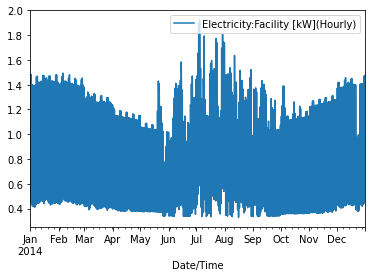

In [80]:
energy_df.plot(x='Date/Time', y='Electricity:Facility [kW](Hourly)')

In these cases, the [rolling mean](https://en.wikipedia.org/wiki/Moving_average) can be a useful technique. By smoothing values over a particular period of time, it can reveal trends that emerge at different time scales. It lets you "zoom out" on the data, so to speak. 

Since the data is hourly, we might want to calculate the rolling mean over a 24-hour period, which would give us a better impression of the trends from day to day. 

Our `for` loop approach to the rolling mean uses pandas indexing and slicing to average over the last 24 hours of data, hour by hour in our dataset. 

In [81]:
mean_kw = []
for i in range(23, len(energy_df)):
    first_idx = i - 23
    period = energy_df.iloc[first_idx:i+1]['Electricity:Facility [kW](Hourly)']
    mean_kw.append(period.mean())

Now we have a list containing the rolling hourly average for this particular measure. But in the process, we've lost our time series axis, which will make it harder to plot.

In [82]:
mean_kw

[0.9143432632930001,
 0.9139998095127083,
 0.9137340674936666,
 0.9134225390485415,
 0.9130468269282085,
 0.912473426051625,
 0.9113334302624584,
 0.9090915483187082,
 0.906413718147875,
 0.9037418691653749,
 0.9013261110280416,
 0.8991547810784999,
 0.8971905246533748,
 0.8953174984504165,
 0.8935593531409999,
 0.891821192805625,
 0.8900182583079167,
 0.8880067307065834,
 0.8852935264474167,
 0.881976895147,
 0.8788142754107501,
 0.8758846930165833,
 0.8733703430961667,
 0.8712343747194584,
 0.8696459382720416,
 0.8689219876508334,
 0.8681776681379167,
 0.8674356882884583,
 0.8667517894094584,
 0.8661160676445835,
 0.8654919461271667,
 0.8648751603217502,
 0.8641045618913333,
 0.8634647505450834,
 0.8628854633446249,
 0.8623566765639583,
 0.861918945098,
 0.8615365990534167,
 0.8611529241010416,
 0.8606457795238333,
 0.860207148600375,
 0.8597074804724999,
 0.8589626133558332,
 0.8583503528870833,
 0.8580914393954165,
 0.8578724353020832,
 0.85761932704375,
 0.8572891575564583,
 0.856

Fortunately, pandas has us covered with another built-in method. We simply specify a period length as an argument to the `rolling` method, then we call one of pandas' aggregate methods on the result of that `rolling` method -- in this case, `mean()`. 

In [83]:
energy_df.rolling(24).mean()

IndexError: list assignment index out of range

We'd like to calculate a rolling mean for all the metrics in our DataFrame. But pandas is now complaining about our newly converted `Date/Time` column -- and we need that column for plotting...

Not to worry. Here's where the pandas index comes in especially handy.

We can make the `Date/Time` column into the index of our DataFrame. Then the `rolling` method won't try to compute with its values, but we can still use those values for plotting. While we're at it, we'll get rid of the intermediate `timestamp` column, since we have no more need of it.

In [84]:
energy_df = energy_df.drop('timestamp', axis=1)
energy_df = energy_df.set_index('Date/Time')

In [85]:
rolling = energy_df.rolling(24).mean()

Now we can see some interesting trend lines for all the different types of utilities/appliances in our dataset.

<AxesSubplot:xlabel='Date/Time'>

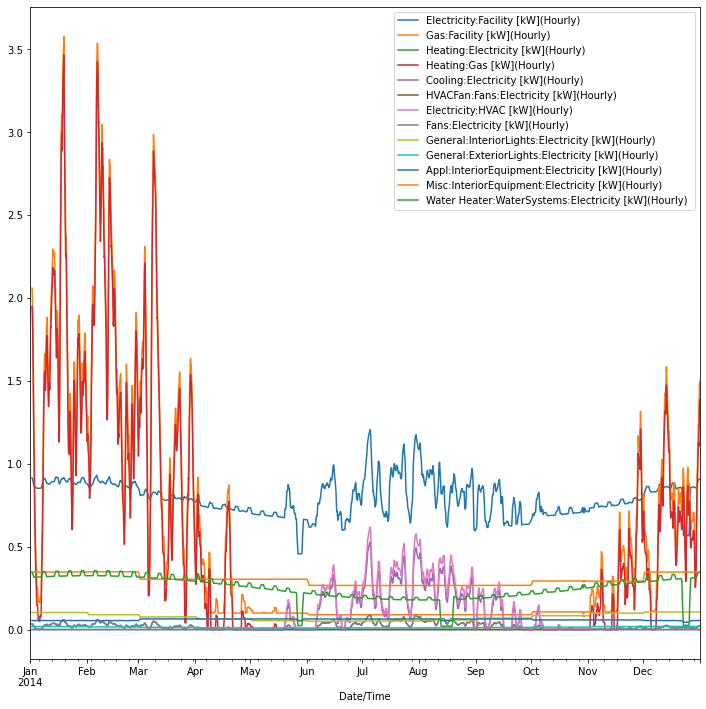

In [86]:
rolling.plot(figsize=(12,12))